In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
RS = 42

In [6]:
# /kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv
df_original=pd.read_csv('./predictive_maintenance.csv')

In [7]:
df_original.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


#### Renaming feature names for convenience

In [8]:
df_original.rename(columns = {'Air temperature [K]': 'Air_temperature', 'Process temperature [K]': 'Process_temperature', 'Rotational speed [rpm]': 'Rotational_speed', 'Torque [Nm]': 'Torque', 'Tool wear [min]': 'Tool_wear'}, inplace = True)

In [9]:
df_original.shape

(10000, 10)

In [10]:
df_original['UDI'].nunique()

10000

In [11]:
df_original['Product ID'].nunique()

10000

Dropping 'UDI', 'Product ID' and 'Failure Type'

In [12]:
df_original.drop(['UDI', 'Product ID', 'Failure Type'], axis = 1, inplace = True)

#### Train test split

In [13]:
from sklearn.model_selection import train_test_split

X = df_original.drop('Target', axis = 1)
Y = df_original['Target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = RS, test_size = 0.05, stratify = Y)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9500, 6), (500, 6), (9500,), (500,))

In [15]:
df = X_train.join(y_train, how = 'inner')
df.sort_index(axis = 0, inplace = True)

#### Checking for duplicate entries

In [16]:
Duplicate = df[df.duplicated(keep = 'first')]
print('Duplicate Entries: ', Duplicate.shape)

Duplicate Entries:  (0, 7)


There are no duplicate entries in the dataset.

## EXPLORATORY DATA ANALYSIS 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9500 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 9500 non-null   object 
 1   Air_temperature      9500 non-null   float64
 2   Process_temperature  9500 non-null   float64
 3   Rotational_speed     9500 non-null   int64  
 4   Torque               9500 non-null   float64
 5   Tool_wear            9500 non-null   int64  
 6   Target               9500 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 593.8+ KB


There are no missing values in the dataset

#### Discrete features

In [18]:
discrete_feature = [feature for feature in df.columns if len(df[feature].unique())<25 and feature not in ['Target']]
print('Discrete variables count: {}'.format(len(discrete_feature)))

Discrete variables count: 1


In [19]:
discrete_feature

['Type']

In [25]:
for feature in discrete_feature:
    plt.figure(figsize=(10,5))
    print('1')
    plot=sns.countplot(df['Type'])
    print(2)

    total = len(df[feature])
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 10)

    plt.show() 

1


ValueError: could not convert string to float: 'M'

<Figure size 1000x500 with 0 Axes>

L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality.

The dataset has 60% of low type product.

In [21]:
for i in discrete_feature:
        plt.figure(figsize=(10,5))
        sns.countplot(df[i],hue=df['Target'])
        plt.show()

ValueError: Cannot use `hue` without `x` and `y`

<Figure size 1000x500 with 0 Axes>

#### Numerical features

In [ ]:
continuous_feature = [feature for feature in df.columns if df[feature].dtypes != 'O' and feature not in discrete_feature+['Target']]

print("Number of numerical features: ", len(continuous_feature))

Number of numerical features:  5


In [ ]:
continuous_feature

['Air_temperature',
 'Process_temperature',
 'Rotational_speed',
 'Torque',
 'Tool_wear']

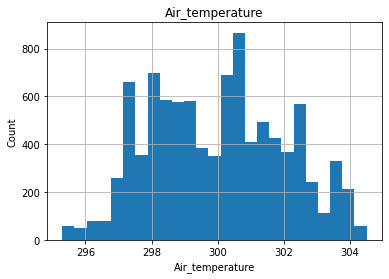

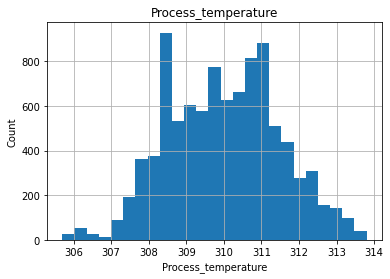

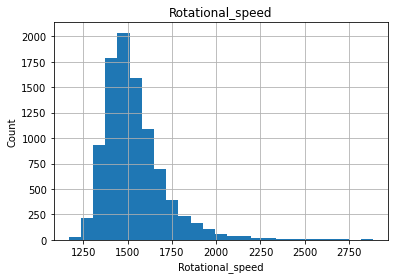

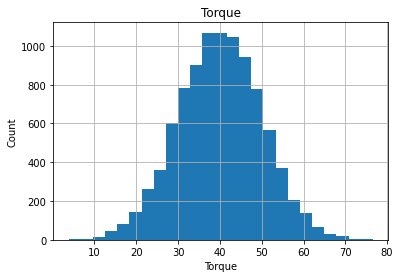

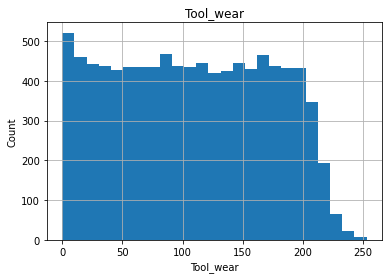

In [ ]:
for feature in continuous_feature:
    data=df.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

Some of the features are skewed.

In [ ]:
from scipy.stats import shapiro

for feature in continuous_feature:
    data = df.copy()
    DataToTest = data[feature]
    stat, p = shapiro(DataToTest)
    print(feature)
    print('stat = %.2f, p = %.30f' % (stat, p))
    
    if p > 0.05:
        print('Normal distribution')
        print()
    else:
        print('Not a normal distribution')
        print()

Air_temperature
stat = 0.98, p = 0.000000000000000000000000000000
Not a normal distribution

Process_temperature
stat = 0.99, p = 0.000000000000000000000243515682
Not a normal distribution

Rotational_speed
stat = 0.86, p = 0.000000000000000000000000000000
Not a normal distribution

Torque
stat = 1.00, p = 0.539811491966247558593750000000
Normal distribution

Tool_wear
stat = 0.96, p = 0.000000000000000000000000000000
Not a normal distribution



/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


- Except Torque all other features are not normally distributed. 

- Let us apply log transformation for the skewed features.

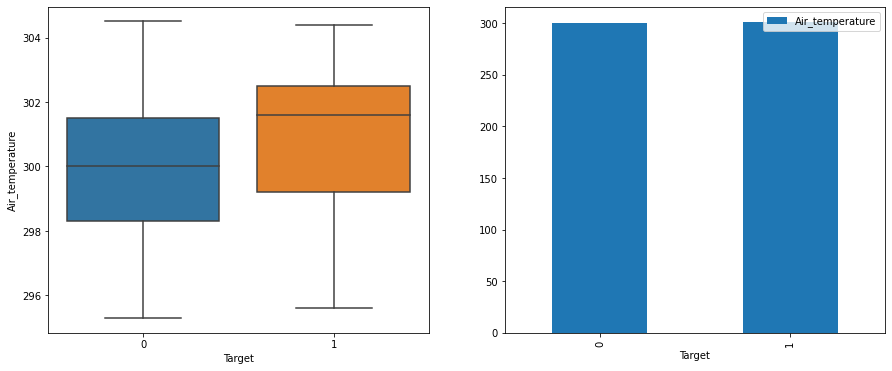

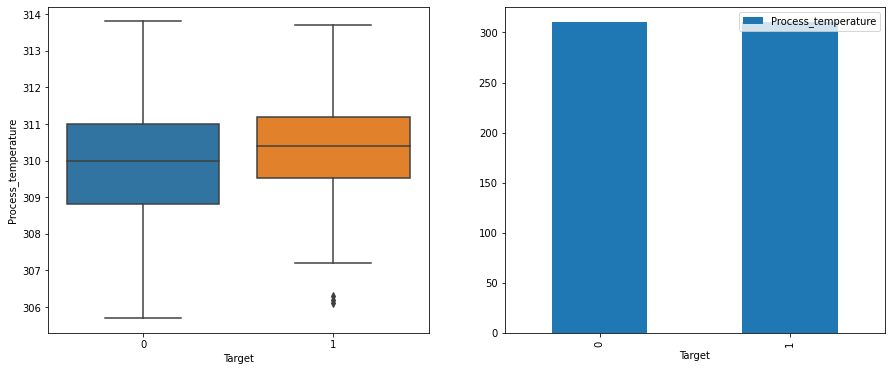

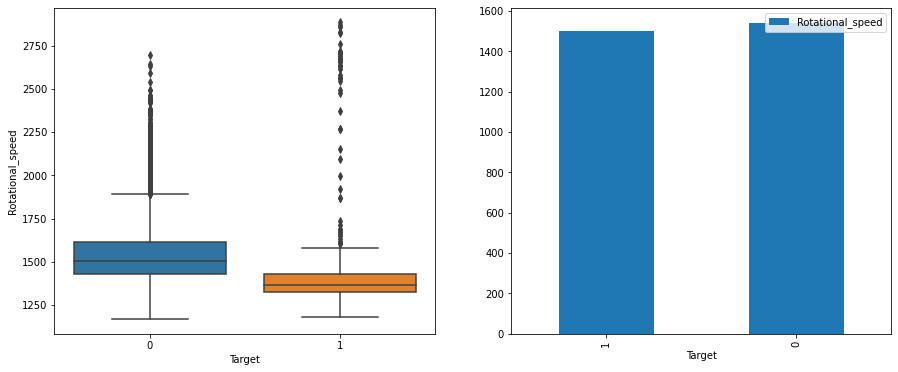

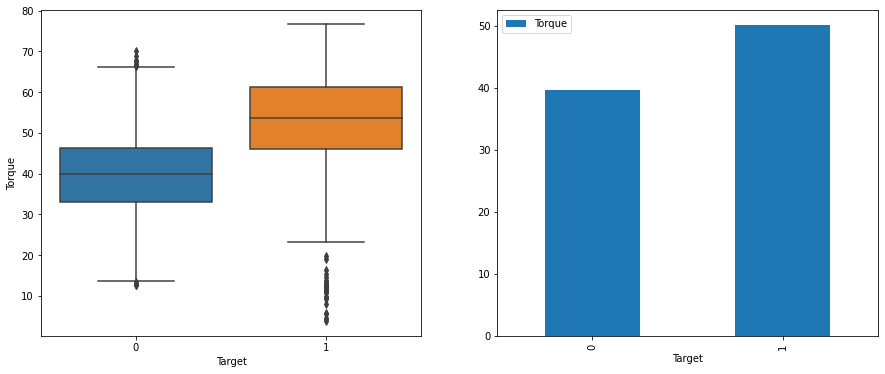

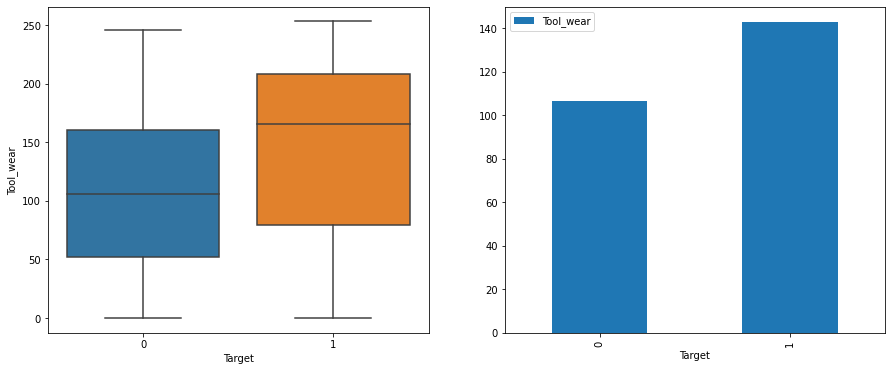

In [ ]:
for i in continuous_feature:
    f,axes=plt.subplots(1,2,figsize=(15,6))
    sns.boxplot(x='Target', y=i, data= df, ax=axes[0])
    df.groupby(by=['Target'])[i].mean().reset_index().sort_values(i,ascending=True).plot(x='Target',y=i,kind='bar',ax=axes[1])

#### Checking for outliers

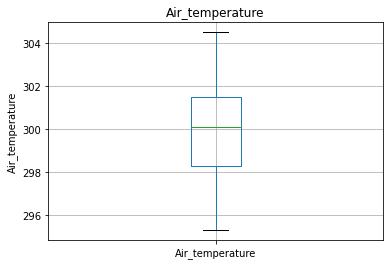

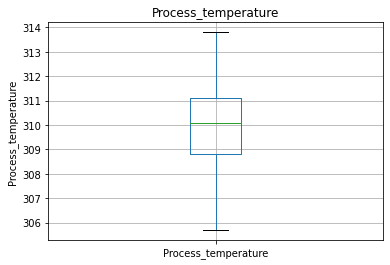

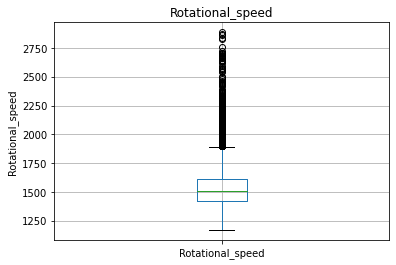

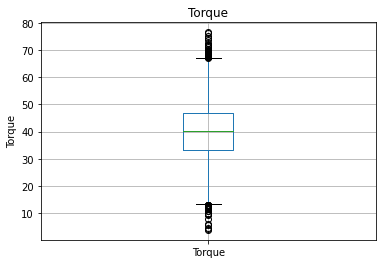

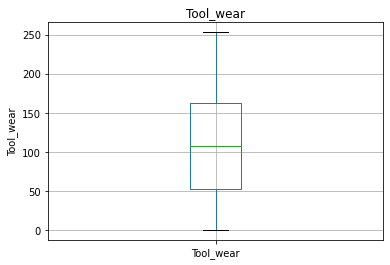

In [ ]:
for feature in continuous_feature:
    
    data = df.copy()
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

- Rotational_speed and Torque have outliers in them.

- We will be using machine learning models that are robust to outliers

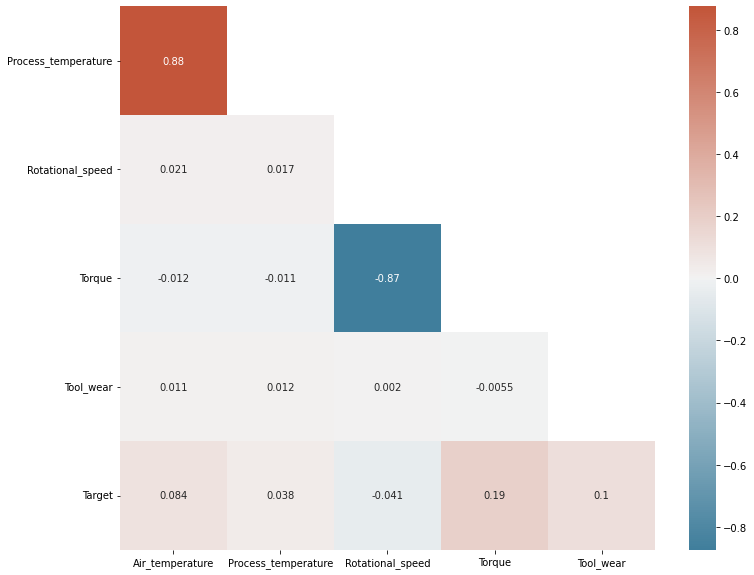

In [ ]:
corr = df.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:,:-1].copy()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.yticks(rotation=0)
plt.show()

***OBSERVATIONS***
- Process_temperature and Air_temperature are highly positively correlated
- Torque and Rotational_speed are highly negatively correlated.

In Feature Selection we will check whether these features are really required for predicting the Target.

## FEATURE ENGINEERING

In [ ]:
X_train_final, X_validation, y_train_final, y_validation = train_test_split(X_train, y_train,  random_state = RS, test_size = 0.20, stratify = y_train)
# X_train_final.sort_index(axis = 0, inplace = True)
# X_validation.sort_index(axis = 0, inplace = True)
# y_train_final.sort_index(axis = 0, inplace = True)
# y_validation.sort_index(axis = 0, inplace = True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord = ['L', 'M', 'H']
ordinal_encoder = OrdinalEncoder(categories = [ord])
X_train_final['Type'] = ordinal_encoder.fit_transform(X_train_final[['Type']])
X_validation['Type'] = ordinal_encoder.transform(X_validation[['Type']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ordinal_encoder.categories_

[array(['L', 'M', 'H'], dtype=object)]

#### Applying Transformations

In [ ]:
from sklearn.preprocessing import FunctionTransformer

to_transform = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Tool_wear']

transformer = FunctionTransformer(np.log1p)
X_train_final[to_transform] = transformer.fit_transform(X_train_final[to_transform])
X_validation[to_transform] = transformer.transform(X_validation[to_transform])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Scaling the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

to_scale = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']

scaler = StandardScaler()
X_train_final[to_scale] = scaler.fit_transform(X_train_final[to_scale])
X_validation[to_scale] = scaler.transform(X_validation[to_scale])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
X_train_final.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
1147,1.0,-1.462450,-1.361179,0.935560,-1.451484,0.696741
8831,2.0,-1.310989,-0.885450,1.131691,-1.330773,0.690436
5936,1.0,0.245252,0.265429,0.118935,-0.274550,-0.193807
7866,0.0,0.245252,1.275705,-0.612284,0.942621,-0.749010
6480,0.0,0.345104,-0.072411,1.392178,-1.350892,0.631836


## FEATURE SELECTION

***Checking for constant, quasi constant features***

In [ ]:
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold = 0.01)
constant_filter.fit(X_train_final)

VarianceThreshold(threshold=0.01)

In [ ]:
constant_filter.get_support().sum()

6

There are no constant and quasi constant features in the dataset.

***Checking for duplicate features***

In [ ]:
X_train_T = X_train_final.T
X_train_T.duplicated().sum()

0

There are no duplicate features in the dataset

***Checking for multicollinearity***

<BarContainer object of 7 artists>

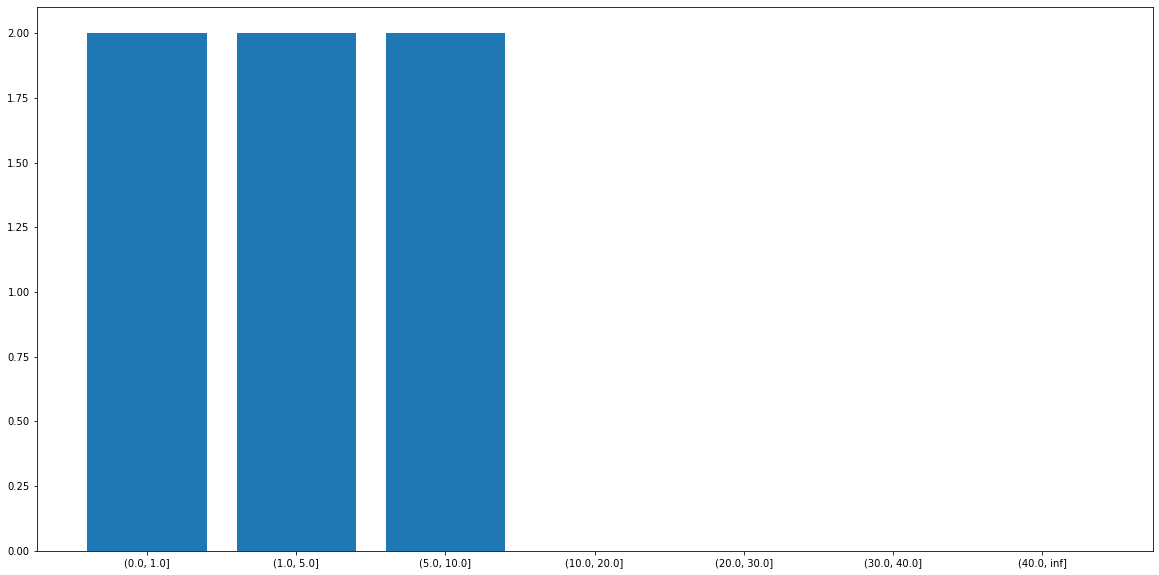

In [ ]:
df = X_train_final.copy()
vif = pd.Series(np.linalg.inv(df.corr().values).diagonal(),index=df.columns,
          name='VIF').abs().sort_values(ascending=False).round(2)
df = pd.cut(vif.round(1),[0,1,5,10,20,30,40,float('inf')]).value_counts().sort_index()
df.index = df.index.map(str)

plt.subplots(figsize=(20, 10))
plt.bar(x=df.index, height=df)

- Generally VIF > 10 is considered as high, None of the features have VIF value greater than 10.

***Feature selection by Recursive Feature Elimination***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

sel = RFE(RandomForestRegressor(n_estimators = 100, random_state = 0, n_jobs = -1))
sel.fit(X_train_final, y_train_final)
sel.get_support()

array([False, False,  True, False,  True,  True])

In [ ]:
features = X_train_final.columns[sel.get_support()]
features

Index(['Process_temperature', 'Torque', 'Tool_wear'], dtype='object')

Only these features contribute in predicting.

In [ ]:
X_train_sel = pd.DataFrame(sel.transform(X_train_final), columns = features)
X_train_sel.shape, y_train_final.shape

((7600, 3), (7600,))

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state = RS)
X_train_upsampled, y_train_upsampled = oversample.fit_resample(X_train_sel, y_train_final)

In [ ]:
X_train_upsampled.shape, y_train_upsampled.shape

((14684, 3), (14684,))

In [ ]:
X_validation_sel = pd.DataFrame(sel.transform(X_validation), columns = features)
X_validation_sel.shape, y_validation.shape

((1900, 3), (1900,))

## MODEL BUILDING

In [ ]:
def fit_models(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test,pred)  
    precision = metrics.precision_score(y_test,pred)   
    recall = metrics.recall_score(y_test,pred)  
    f1 = metrics.f1_score(y_test,pred)
    loss = metrics.log_loss(y_test,pred)
    
    return accuracy, precision, recall, f1, loss

In [ ]:
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

lr = LogisticRegression(random_state = RS)
gnb = GaussianNB()
knn = KNeighborsClassifier()
svm = SVC(random_state = RS)
dT_gini = DecisionTreeClassifier(random_state = RS)
dT_entropy = DecisionTreeClassifier(random_state = RS)
bgcl = BaggingClassifier(n_estimators=100,random_state = RS)
abcl = AdaBoostClassifier(n_estimators=100, random_state = RS)
gbcl = GradientBoostingClassifier(n_estimators = 100,random_state = RS)
rfcl = RandomForestClassifier(n_estimators = 100, random_state = RS)
xgbcl = XGBClassifier(n_estimators = 100, random_state = RS)

result = {}

for model,name in zip([lr, gnb, knn, svm, dT_gini, dT_entropy, bgcl, abcl, gbcl, rfcl, xgbcl],
                     ['Logistic Regression', 'Gaussian NB', 'KNN', 'SVC', 'Decision Tree(gini)',
                     'Decision Tree(entropy)', 'Bagging Classifier', 'Adaptive Boosting', 
                      'Gradient Boosting', 'Random Forest Classifier', 'XGB Classifier']):
    result[name] = fit_models(model,X_train_upsampled, X_validation_sel, y_train_upsampled, y_validation)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
result1 = pd.DataFrame(np.array(list(result.values())),    # make a dataframe out of the metrics from result dictionary 
                       columns= ['ACCURACY', 'PRECISION', 'RECALL', 'F1-SCORE', 'LOG LOSS'], 
                       index= result.keys())   # use the model names as index

result1.index.name = 'Model'   # name the index of the result1 dataframe as 'Model'

result1 

,ACCURACY,PRECISION,RECALL,F1-SCORE,LOG LOSS
Model,,,,,
Logistic Regression,0.732105,0.085661,0.718750,0.153078,9.252963
Gaussian NB,0.788947,0.112644,0.765625,0.196393,7.289662
KNN,0.896316,0.199095,0.687500,0.308772,3.581200
SVC,0.824737,0.146982,0.875000,0.251685,6.053512
Decision Tree(gini),0.931579,0.260870,0.562500,0.356436,2.363222
Decision Tree(entropy),0.931579,0.260870,0.562500,0.356436,2.363222
Bagging Classifier,0.937368,0.286822,0.578125,0.383420,2.163257
Adaptive Boosting,0.879474,0.193309,0.812500,0.312312,4.162923
Gradient Boosting,0.858421,0.172524,0.843750,0.286472,4.890073


XGB Classifier outperforms the other models. Let us build our models using XGB Classifier.

### XGB Classifier

In [ ]:
xgb_clf = XGBClassifier(n_estimators = 100, random_state = RS)
xgb_clf.fit(X_train_upsampled, y_train_upsampled)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


pred = xgb_clf.predict(X_validation_sel)
report = pd.DataFrame(classification_report(y_validation, pred, output_dict=True)).T
report

,precision,recall,f1-score,support
0,0.984092,0.977124,0.980596,1836.000000
1,0.454545,0.546875,0.496454,64.000000
accuracy,0.962632,0.962632,0.962632,0.962632
macro avg,0.719319,0.762000,0.738525,1900.000000
weighted avg,0.966255,0.962632,0.964288,1900.000000


***Hyperparameter tuning***

In [ ]:
params={'n_estimators':[500,700,800,900],
       'max_depth':[1,3,5,7,9],
       'learning_rate':[0.01,0.1],
        'objective':['binary:logistic'],
        'eval_metric':['error']
       }

In [ ]:
xgb_clf_hp = XGBClassifier(use_label_encoder=False)

grd_xgb = GridSearchCV(xgb_clf_hp, param_grid=params, cv=2)

In [ ]:
grd_xgb.fit(X_train_upsampled, y_train_upsampled)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_

In [ ]:
grd_xgb.best_params_

{'eval_metric': 'error',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 800,
 'objective': 'binary:logistic'}

In [ ]:
xgb_clf_hp = XGBClassifier(**grd_xgb.best_params_)

In [ ]:
xgb_clf_hp.fit(X_train_upsampled, y_train_upsampled)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
pred = xgb_clf_hp.predict(X_validation_sel)
report = pd.DataFrame(classification_report(y_validation, pred, output_dict=True)).T
report

,precision,recall,f1-score,support
0,0.981987,0.979847,0.980916,1836.000000
1,0.455882,0.484375,0.469697,64.000000
accuracy,0.963158,0.963158,0.963158,0.963158
macro avg,0.718935,0.732111,0.725307,1900.000000
weighted avg,0.964265,0.963158,0.963696,1900.000000


## Testing our model with new data

In [ ]:
X_test.shape, y_test.shape

((500, 6), (500,))

In [ ]:
X_test['Type'] = ordinal_encoder.transform(X_test[['Type']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test[to_transform] = transformer.transform(X_test[to_transform])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
X_test_sel = pd.DataFrame(sel.transform(X_test), columns = features)


### Prediction by original model

In [ ]:
pred = xgb_clf.predict(X_test_sel)
report = pd.DataFrame(classification_report(y_test, pred, output_dict=True)).T
report

,precision,recall,f1-score,support
0,0.985325,0.973085,0.979167,483.00
1,0.434783,0.588235,0.500000,17.00
accuracy,0.960000,0.960000,0.960000,0.96
macro avg,0.710054,0.780660,0.739583,500.00
weighted avg,0.966607,0.960000,0.962875,500.00


### Prediction by hyperparameter tuned model

In [ ]:
pred = xgb_clf_hp.predict(X_test_sel)
report = pd.DataFrame(classification_report(y_test, pred, output_dict=True)).T
report

,precision,recall,f1-score,support
0,0.981366,0.981366,0.981366,483.000
1,0.470588,0.470588,0.470588,17.000
accuracy,0.964000,0.964000,0.964000,0.964
macro avg,0.725977,0.725977,0.725977,500.000
weighted avg,0.964000,0.964000,0.964000,500.000
